In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [3]:
!mkdir -p datasets/test models/unet/ preprocess utils

In [ ]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz


In [4]:
# Test images
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_8band.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_test_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_test_AOI_1_Rio_8band.tar.gz


In [ ]:
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_3band.tar.gz -C datasets/test/
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_8band.tar.gz -C datasets/test/

In [ ]:
!rm -rf datasets/3band
!rm -rf datasets/8band
!rm -rf datasets/geojson

In [ ]:
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz -C datasets/

In [6]:
import os
from os.path import join

In [ ]:
image_3b = "datasets/3band"
image_8b = "datasets/8band"
geojson = "datasets/geojson"
print(len([name for name in os.listdir(image_3b)]), "3b images")
print(len([name for name in os.listdir(image_8b)]), "8b images")
print(len([name for name in os.listdir(geojson)]), "geojson labels")

6940 3b images
6940 8b images
6940 geojson labels


In [ ]:
!pip install rasterio

In [ ]:
import importlib
import models.CreateDataLoaders
import models.CreateDataset
import preprocess.SplitDataset
importlib.reload(models.CreateDataLoaders)
importlib.reload(models.CreateDataset)
# importlib.reload(preprocess.SplitDataset)

<module 'models.CreateDataset' from '/content/models/CreateDataset.py'>

In [ ]:
from preprocess.SplitDataset import SplitDataset

target_dir = "/content/train/"
os.makedirs(target_dir, exist_ok=True)
SplitDataset(
    data_dir="/content/datasets",
    target_dir=target_dir
)


[INFO] Copying 5899 files to 'train/'...


Copying to train: 100%|██████████| 5899/5899 [00:08<00:00, 703.81file/s]


[✓] train set created with 5899 image-mask pairs.

[INFO] Copying 1041 files to 'val/'...


Copying to val: 100%|██████████| 1041/1041 [00:02<00:00, 350.71file/s]

[✓] val set created with 1041 image-mask pairs.
[Done] Dataset split into train/val/test folders under: /content/train/


In [ ]:
!rm -rf train/train/mask/
!rm -rf train/val/mask

In [ ]:
from preprocess.CreateMaskRasterio import convert_geojsons_to_masks
folders = ["train", "val"]

for folder in folders:
  source_dir = os.path.join(target_dir, folder, "8band")
  geojson_dir = os.path.join(target_dir, folder, "geojson")
  mask_dir = os.path.join(target_dir, folder, "mask")
  convert_geojsons_to_masks(geojson_dir, source_dir, mask_dir)

Creating masks: 100%|██████████| 1041/1041 [00:13<00:00, 79.11it/s] 


In [ ]:
folders = ["train", "val"]
subfolders = ["3band", "8band", "geojson", "mask"]

for folder in folders:
    for subfolder in subfolders:
        folder_path = os.path.join(target_dir, folder, subfolder)
        print(len([name for name in os.listdir(folder_path)]), folder + "/" + subfolder)

5899 train/3band
5899 train/8band
5899 train/geojson
5899 train/mask
1041 val/3band
1041 val/8band
1041 val/geojson
1041 val/mask


In [ ]:
from models.CreateDataLoaders import CreateDataLoaders
train_loader, val_loader = CreateDataLoaders(128, 128, target_dir, batch_size=32, num_workers=4)
print(train_loader)
print(val_loader)

Found 5899 valid image-mask pairs
Found 1041 valid image-mask pairs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Initialize model
from models.unet.model import UNet
model = UNet(num_classes=1, in_channels=8, depth=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model = model.to(device)

Using device:  cuda


In [ ]:
from DiceBCELoss import DiceBCELoss
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [8]:
checkpoint_path = "checkpoint.pth"
model_path = '/content/building_segmentation_model_3band_128_23-5.pth'

In [9]:
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from next epoch
    print(f"[✓] Loaded checkpoint from epoch {start_epoch}")
else:
    print("[INFO] No checkpoint found. Training from scratch.")

[INFO] No checkpoint found. Training from scratch.


In [ ]:
from tqdm import tqdm

# Trainig Loop
num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.sigmoid(outputs) > 0.5
        acc = (pred == masks).float().mean()

        train_loss += loss.item()
        train_acc += acc.item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": acc.item()
        })

    # Validation phase
    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice coefficient
            pred = torch.sigmoid(outputs) > 0.5
            dice_score += (2 * (pred * masks).sum()) / ((pred + masks).sum() + 1e-8)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Dice: {dice_score/len(val_loader):.4f}')

    # Update learning rate based on validation losp
    scheduler.step(val_loss)

Epoch 1/100: 100%|██████████| 185/185 [00:11<00:00, 16.48it/s, loss=1.1, acc=0.754]


Epoch 1/100, Train Loss: 1.0269, Val Loss: 0.7160, Dice: 0.5575


Epoch 2/100: 100%|██████████| 185/185 [00:10<00:00, 18.44it/s, loss=0.981, acc=0.882]


Epoch 2/100, Train Loss: 1.0448, Val Loss: 0.8664, Dice: 0.3613


Epoch 3/100: 100%|██████████| 185/185 [00:09<00:00, 18.64it/s, loss=0.732, acc=0.91]


Epoch 3/100, Train Loss: 0.8668, Val Loss: 0.6737, Dice: 0.6025


Epoch 4/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.724, acc=0.911]


Epoch 4/100, Train Loss: 0.8449, Val Loss: 0.6693, Dice: 0.6011


Epoch 5/100: 100%|██████████| 185/185 [00:09<00:00, 18.58it/s, loss=0.651, acc=0.915]


Epoch 5/100, Train Loss: 0.7693, Val Loss: 0.7513, Dice: 0.5672


Epoch 6/100: 100%|██████████| 185/185 [00:10<00:00, 18.39it/s, loss=0.602, acc=0.915]


Epoch 6/100, Train Loss: 0.7428, Val Loss: 0.6020, Dice: 0.6245


Epoch 7/100: 100%|██████████| 185/185 [00:09<00:00, 18.52it/s, loss=0.727, acc=0.89]


Epoch 7/100, Train Loss: 0.7036, Val Loss: 0.6196, Dice: 0.6184


Epoch 8/100: 100%|██████████| 185/185 [00:09<00:00, 18.75it/s, loss=0.62, acc=0.929]


Epoch 8/100, Train Loss: 0.6858, Val Loss: 0.6363, Dice: 0.6164


Epoch 9/100: 100%|██████████| 185/185 [00:09<00:00, 18.74it/s, loss=0.703, acc=0.956]


Epoch 9/100, Train Loss: 0.6756, Val Loss: 0.5912, Dice: 0.6399


Epoch 10/100: 100%|██████████| 185/185 [00:09<00:00, 18.62it/s, loss=0.903, acc=0.841]


Epoch 10/100, Train Loss: 0.6869, Val Loss: 0.5626, Dice: 0.6488


Epoch 11/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.605, acc=0.968]


Epoch 11/100, Train Loss: 0.6757, Val Loss: 0.5876, Dice: 0.6181


Epoch 12/100: 100%|██████████| 185/185 [00:09<00:00, 18.57it/s, loss=0.543, acc=0.964]


Epoch 12/100, Train Loss: 0.6731, Val Loss: 0.5516, Dice: 0.6593


Epoch 13/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.527, acc=0.924]


Epoch 13/100, Train Loss: 0.6596, Val Loss: 0.5517, Dice: 0.6640


Epoch 14/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.628, acc=0.899]


Epoch 14/100, Train Loss: 0.6615, Val Loss: 0.5707, Dice: 0.6544


Epoch 15/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.54, acc=0.94]


Epoch 15/100, Train Loss: 0.6623, Val Loss: 0.5330, Dice: 0.6697


Epoch 16/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.599, acc=0.94]


Epoch 16/100, Train Loss: 0.6623, Val Loss: 0.5323, Dice: 0.6697


Epoch 17/100: 100%|██████████| 185/185 [00:10<00:00, 18.47it/s, loss=0.524, acc=0.925]


Epoch 17/100, Train Loss: 0.7076, Val Loss: 0.5552, Dice: 0.6560


Epoch 18/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.58, acc=0.928]


Epoch 18/100, Train Loss: 0.6412, Val Loss: 0.5558, Dice: 0.6603


Epoch 19/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.565, acc=0.952]


Epoch 19/100, Train Loss: 0.6424, Val Loss: 0.5267, Dice: 0.6716


Epoch 20/100: 100%|██████████| 185/185 [00:09<00:00, 18.79it/s, loss=0.605, acc=0.913]


Epoch 20/100, Train Loss: 0.6468, Val Loss: 0.5710, Dice: 0.6425


Epoch 21/100: 100%|██████████| 185/185 [00:09<00:00, 18.62it/s, loss=0.627, acc=0.902]


Epoch 21/100, Train Loss: 0.6361, Val Loss: 0.5182, Dice: 0.6775


Epoch 22/100: 100%|██████████| 185/185 [00:09<00:00, 18.95it/s, loss=0.495, acc=0.957]


Epoch 22/100, Train Loss: 0.6341, Val Loss: 0.5276, Dice: 0.6813


Epoch 23/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.504, acc=0.954]


Epoch 23/100, Train Loss: 0.6337, Val Loss: 0.5181, Dice: 0.6764


Epoch 24/100: 100%|██████████| 185/185 [00:10<00:00, 18.32it/s, loss=0.508, acc=0.96]


Epoch 24/100, Train Loss: 0.6398, Val Loss: 0.5289, Dice: 0.6671


Epoch 25/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.592, acc=0.92]


Epoch 25/100, Train Loss: 0.6276, Val Loss: 0.5417, Dice: 0.6559


Epoch 26/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.441, acc=0.977]


Epoch 26/100, Train Loss: 0.6355, Val Loss: 0.5620, Dice: 0.6506


Epoch 27/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.578, acc=0.974]


Epoch 27/100, Train Loss: 0.6335, Val Loss: 0.5177, Dice: 0.6814


Epoch 28/100: 100%|██████████| 185/185 [00:09<00:00, 18.82it/s, loss=0.684, acc=0.871]


Epoch 28/100, Train Loss: 0.6279, Val Loss: 0.5286, Dice: 0.6739


Epoch 29/100: 100%|██████████| 185/185 [00:09<00:00, 18.60it/s, loss=0.86, acc=0.95]


Epoch 29/100, Train Loss: 0.6319, Val Loss: 0.6063, Dice: 0.6403


Epoch 30/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.472, acc=0.961]


Epoch 30/100, Train Loss: 0.6364, Val Loss: 0.5253, Dice: 0.6725


Epoch 31/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.553, acc=0.953]


Epoch 31/100, Train Loss: 0.6328, Val Loss: 0.5179, Dice: 0.6798


Epoch 32/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.499, acc=0.942]


Epoch 32/100, Train Loss: 0.6359, Val Loss: 0.5302, Dice: 0.6703


Epoch 33/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.585, acc=0.952]


Epoch 33/100, Train Loss: 0.6202, Val Loss: 0.5140, Dice: 0.6820


Epoch 34/100: 100%|██████████| 185/185 [00:10<00:00, 18.40it/s, loss=0.608, acc=0.896]


Epoch 34/100, Train Loss: 0.6117, Val Loss: 0.5199, Dice: 0.6802


Epoch 35/100: 100%|██████████| 185/185 [00:10<00:00, 18.46it/s, loss=0.634, acc=0.904]


Epoch 35/100, Train Loss: 0.6258, Val Loss: 0.5137, Dice: 0.6840


Epoch 36/100: 100%|██████████| 185/185 [00:10<00:00, 18.49it/s, loss=0.984, acc=0.911]


Epoch 36/100, Train Loss: 0.6360, Val Loss: 0.5447, Dice: 0.6646


Epoch 37/100: 100%|██████████| 185/185 [00:09<00:00, 18.65it/s, loss=0.633, acc=0.967]


Epoch 37/100, Train Loss: 0.6342, Val Loss: 0.5480, Dice: 0.6634


Epoch 38/100: 100%|██████████| 185/185 [00:10<00:00, 18.36it/s, loss=0.531, acc=0.957]


Epoch 38/100, Train Loss: 0.6119, Val Loss: 0.5297, Dice: 0.6742


Epoch 39/100: 100%|██████████| 185/185 [00:09<00:00, 18.88it/s, loss=0.449, acc=0.961]


Epoch 39/100, Train Loss: 0.6060, Val Loss: 0.5062, Dice: 0.6894


Epoch 40/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.642, acc=0.915]


Epoch 40/100, Train Loss: 0.6067, Val Loss: 0.5030, Dice: 0.6900


Epoch 41/100: 100%|██████████| 185/185 [00:09<00:00, 18.89it/s, loss=0.531, acc=0.966]


Epoch 41/100, Train Loss: 0.6109, Val Loss: 0.4966, Dice: 0.6897


Epoch 42/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.664, acc=0.979]


Epoch 42/100, Train Loss: 0.6039, Val Loss: 0.5284, Dice: 0.6706


Epoch 43/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.614, acc=0.971]


Epoch 43/100, Train Loss: 0.5932, Val Loss: 0.5063, Dice: 0.6907


Epoch 44/100: 100%|██████████| 185/185 [00:09<00:00, 18.77it/s, loss=0.566, acc=0.945]


Epoch 44/100, Train Loss: 0.6063, Val Loss: 0.5028, Dice: 0.6902


Epoch 45/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.496, acc=0.959]


Epoch 45/100, Train Loss: 0.5946, Val Loss: 0.5156, Dice: 0.6798


Epoch 46/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.57, acc=0.966]


Epoch 46/100, Train Loss: 0.5947, Val Loss: 0.5073, Dice: 0.6811


Epoch 47/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.494, acc=0.959]


Epoch 47/100, Train Loss: 0.5947, Val Loss: 0.5134, Dice: 0.6878


Epoch 48/100: 100%|██████████| 185/185 [00:09<00:00, 18.63it/s, loss=0.306, acc=0.984]


Epoch 48/100, Train Loss: 0.5768, Val Loss: 0.4939, Dice: 0.6950


Epoch 49/100: 100%|██████████| 185/185 [00:09<00:00, 18.61it/s, loss=0.45, acc=0.985]


Epoch 49/100, Train Loss: 0.5670, Val Loss: 0.5005, Dice: 0.6881


Epoch 50/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.577, acc=0.919]


Epoch 50/100, Train Loss: 0.5814, Val Loss: 0.4833, Dice: 0.7013


Epoch 51/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.558, acc=0.935]


Epoch 51/100, Train Loss: 0.5719, Val Loss: 0.4877, Dice: 0.6985


Epoch 52/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.547, acc=0.927]


Epoch 52/100, Train Loss: 0.5783, Val Loss: 0.4951, Dice: 0.6963


Epoch 53/100: 100%|██████████| 185/185 [00:09<00:00, 18.92it/s, loss=0.387, acc=0.967]


Epoch 53/100, Train Loss: 0.5656, Val Loss: 0.4914, Dice: 0.6961


Epoch 54/100: 100%|██████████| 185/185 [00:09<00:00, 18.73it/s, loss=0.548, acc=0.939]


Epoch 54/100, Train Loss: 0.5779, Val Loss: 0.5088, Dice: 0.6907


Epoch 55/100: 100%|██████████| 185/185 [00:09<00:00, 18.64it/s, loss=0.685, acc=0.929]


Epoch 55/100, Train Loss: 0.5827, Val Loss: 0.4923, Dice: 0.6976


Epoch 56/100: 100%|██████████| 185/185 [00:09<00:00, 18.60it/s, loss=0.536, acc=0.973]


Epoch 56/100, Train Loss: 0.5723, Val Loss: 0.4928, Dice: 0.6988


Epoch 57/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.68, acc=0.891]


Epoch 57/100, Train Loss: 0.5651, Val Loss: 0.4842, Dice: 0.6994


Epoch 58/100: 100%|██████████| 185/185 [00:09<00:00, 18.70it/s, loss=0.55, acc=0.92]


Epoch 58/100, Train Loss: 0.5566, Val Loss: 0.4806, Dice: 0.7037


Epoch 59/100: 100%|██████████| 185/185 [00:09<00:00, 18.99it/s, loss=0.523, acc=0.925]


Epoch 59/100, Train Loss: 0.5542, Val Loss: 0.4795, Dice: 0.7029


Epoch 60/100: 100%|██████████| 185/185 [00:09<00:00, 18.66it/s, loss=0.468, acc=0.947]


Epoch 60/100, Train Loss: 0.5508, Val Loss: 0.4821, Dice: 0.7015


Epoch 61/100: 100%|██████████| 185/185 [00:09<00:00, 18.71it/s, loss=0.463, acc=0.977]


Epoch 61/100, Train Loss: 0.5531, Val Loss: 0.4821, Dice: 0.7018


Epoch 62/100: 100%|██████████| 185/185 [00:09<00:00, 18.79it/s, loss=0.376, acc=0.939]


Epoch 62/100, Train Loss: 0.5494, Val Loss: 0.4823, Dice: 0.7028


Epoch 63/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.643, acc=0.906]


Epoch 63/100, Train Loss: 0.5511, Val Loss: 0.4777, Dice: 0.7035


Epoch 64/100: 100%|██████████| 185/185 [00:09<00:00, 18.76it/s, loss=0.571, acc=0.939]


Epoch 64/100, Train Loss: 0.5551, Val Loss: 0.4808, Dice: 0.7036


Epoch 65/100: 100%|██████████| 185/185 [00:09<00:00, 18.61it/s, loss=0.591, acc=0.911]


Epoch 65/100, Train Loss: 0.5585, Val Loss: 0.4834, Dice: 0.6994


Epoch 66/100: 100%|██████████| 185/185 [00:09<00:00, 18.72it/s, loss=0.417, acc=0.959]


Epoch 66/100, Train Loss: 0.5493, Val Loss: 0.4847, Dice: 0.7008


Epoch 67/100: 100%|██████████| 185/185 [00:09<00:00, 18.69it/s, loss=0.561, acc=0.922]


Epoch 67/100, Train Loss: 0.5534, Val Loss: 0.4808, Dice: 0.7019


Epoch 68/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.479, acc=0.957]


Epoch 68/100, Train Loss: 0.5560, Val Loss: 0.4842, Dice: 0.7050


Epoch 69/100: 100%|██████████| 185/185 [00:09<00:00, 18.80it/s, loss=0.545, acc=0.917]


Epoch 69/100, Train Loss: 0.5611, Val Loss: 0.4814, Dice: 0.7025


Epoch 70/100: 100%|██████████| 185/185 [00:09<00:00, 19.03it/s, loss=0.528, acc=0.948]


Epoch 70/100, Train Loss: 0.5435, Val Loss: 0.4742, Dice: 0.7053


Epoch 71/100: 100%|██████████| 185/185 [00:09<00:00, 19.12it/s, loss=0.481, acc=0.928]


Epoch 71/100, Train Loss: 0.5468, Val Loss: 0.4768, Dice: 0.7043


Epoch 72/100: 100%|██████████| 185/185 [00:09<00:00, 18.97it/s, loss=0.387, acc=0.966]


Epoch 72/100, Train Loss: 0.5405, Val Loss: 0.4736, Dice: 0.7051


Epoch 73/100: 100%|██████████| 185/185 [00:09<00:00, 19.10it/s, loss=0.472, acc=0.971]


Epoch 73/100, Train Loss: 0.5488, Val Loss: 0.4783, Dice: 0.7036


Epoch 74/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.59, acc=0.912]


Epoch 74/100, Train Loss: 0.5504, Val Loss: 0.4793, Dice: 0.7049


Epoch 75/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.56, acc=0.907]


Epoch 75/100, Train Loss: 0.5481, Val Loss: 0.4769, Dice: 0.7032


Epoch 76/100: 100%|██████████| 185/185 [00:09<00:00, 18.65it/s, loss=0.557, acc=0.946]


Epoch 76/100, Train Loss: 0.5431, Val Loss: 0.4763, Dice: 0.7042


Epoch 77/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.476, acc=0.962]


Epoch 77/100, Train Loss: 0.5544, Val Loss: 0.4769, Dice: 0.7062


Epoch 78/100: 100%|██████████| 185/185 [00:09<00:00, 18.78it/s, loss=0.568, acc=0.912]


Epoch 78/100, Train Loss: 0.5397, Val Loss: 0.4815, Dice: 0.7056


Epoch 79/100: 100%|██████████| 185/185 [00:09<00:00, 18.93it/s, loss=0.403, acc=0.958]


Epoch 79/100, Train Loss: 0.5336, Val Loss: 0.4724, Dice: 0.7077


Epoch 80/100: 100%|██████████| 185/185 [00:09<00:00, 18.85it/s, loss=0.51, acc=0.926]


Epoch 80/100, Train Loss: 0.5355, Val Loss: 0.4751, Dice: 0.7043


Epoch 81/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.415, acc=0.975]


Epoch 81/100, Train Loss: 0.5383, Val Loss: 0.4724, Dice: 0.7082


Epoch 82/100: 100%|██████████| 185/185 [00:09<00:00, 19.09it/s, loss=0.499, acc=0.927]


Epoch 82/100, Train Loss: 0.5382, Val Loss: 0.4740, Dice: 0.7059


Epoch 83/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.472, acc=0.947]


Epoch 83/100, Train Loss: 0.5399, Val Loss: 0.4730, Dice: 0.7059


Epoch 84/100: 100%|██████████| 185/185 [00:09<00:00, 19.19it/s, loss=0.484, acc=0.921]


Epoch 84/100, Train Loss: 0.5404, Val Loss: 0.4756, Dice: 0.7070


Epoch 85/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.381, acc=0.985]


Epoch 85/100, Train Loss: 0.5390, Val Loss: 0.4717, Dice: 0.7083


Epoch 86/100: 100%|██████████| 185/185 [00:09<00:00, 18.94it/s, loss=0.569, acc=0.919]


Epoch 86/100, Train Loss: 0.5387, Val Loss: 0.4727, Dice: 0.7071


Epoch 87/100: 100%|██████████| 185/185 [00:09<00:00, 18.83it/s, loss=0.47, acc=0.949]


Epoch 87/100, Train Loss: 0.5330, Val Loss: 0.4741, Dice: 0.7066


Epoch 88/100: 100%|██████████| 185/185 [00:09<00:00, 18.87it/s, loss=0.427, acc=0.969]


Epoch 88/100, Train Loss: 0.5348, Val Loss: 0.4741, Dice: 0.7054


Epoch 89/100: 100%|██████████| 185/185 [00:09<00:00, 19.04it/s, loss=0.514, acc=0.93]


Epoch 89/100, Train Loss: 0.5420, Val Loss: 0.4733, Dice: 0.7061


Epoch 90/100: 100%|██████████| 185/185 [00:09<00:00, 19.09it/s, loss=0.478, acc=0.944]


Epoch 90/100, Train Loss: 0.5308, Val Loss: 0.4729, Dice: 0.7060


Epoch 91/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.594, acc=0.92]


Epoch 91/100, Train Loss: 0.5353, Val Loss: 0.4726, Dice: 0.7074


Epoch 92/100: 100%|██████████| 185/185 [00:09<00:00, 18.84it/s, loss=0.483, acc=0.964]


Epoch 92/100, Train Loss: 0.5394, Val Loss: 0.4732, Dice: 0.7082


Epoch 93/100: 100%|██████████| 185/185 [00:09<00:00, 19.01it/s, loss=0.534, acc=0.911]


Epoch 93/100, Train Loss: 0.5377, Val Loss: 0.4727, Dice: 0.7073


Epoch 94/100: 100%|██████████| 185/185 [00:09<00:00, 19.03it/s, loss=0.584, acc=0.929]


Epoch 94/100, Train Loss: 0.5349, Val Loss: 0.4712, Dice: 0.7075


Epoch 95/100: 100%|██████████| 185/185 [00:09<00:00, 18.74it/s, loss=0.387, acc=0.949]


Epoch 95/100, Train Loss: 0.5383, Val Loss: 0.4738, Dice: 0.7069


Epoch 96/100: 100%|██████████| 185/185 [00:09<00:00, 18.98it/s, loss=0.56, acc=0.919]


Epoch 96/100, Train Loss: 0.5327, Val Loss: 0.4708, Dice: 0.7080


Epoch 97/100: 100%|██████████| 185/185 [00:09<00:00, 18.93it/s, loss=0.486, acc=0.97]


Epoch 97/100, Train Loss: 0.5347, Val Loss: 0.4724, Dice: 0.7073


Epoch 98/100: 100%|██████████| 185/185 [00:09<00:00, 18.81it/s, loss=0.491, acc=0.934]


Epoch 98/100, Train Loss: 0.5301, Val Loss: 0.4721, Dice: 0.7071


Epoch 99/100: 100%|██████████| 185/185 [00:09<00:00, 18.76it/s, loss=0.424, acc=0.96]


Epoch 99/100, Train Loss: 0.5392, Val Loss: 0.4726, Dice: 0.7077


Epoch 100/100: 100%|██████████| 185/185 [00:09<00:00, 18.86it/s, loss=0.363, acc=0.973]


Epoch 100/100, Train Loss: 0.5370, Val Loss: 0.4725, Dice: 0.7077


In [ ]:
# Save checkpoint after each epoch
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "train_loss": avg_train_loss,
    "val_loss": val_loss / len(val_loader),
    "dice_score": dice_score / len(val_loader)
}, checkpoint_path)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), model_path)

In [ ]:
# Clean up
del model, train_loader, val_loader, outputs, loss
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()

302

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Test

In [12]:
from models.unet.model import UNet
import torch

# Create the model with the same config as during training
model = UNet(num_classes=1, in_channels=3, depth=5)

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=device)
  model.load_state_dict(checkpoint["model_state_dict"])
else:
  model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

/content/models/unet/model.py:211: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/models/unet/model.py:212: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

In [ ]:
import importlib
import utils.Utilities
importlib.reload(utils.Utilities)

<module 'utils.Utilities' from '/content/utils/Utilities.py'>

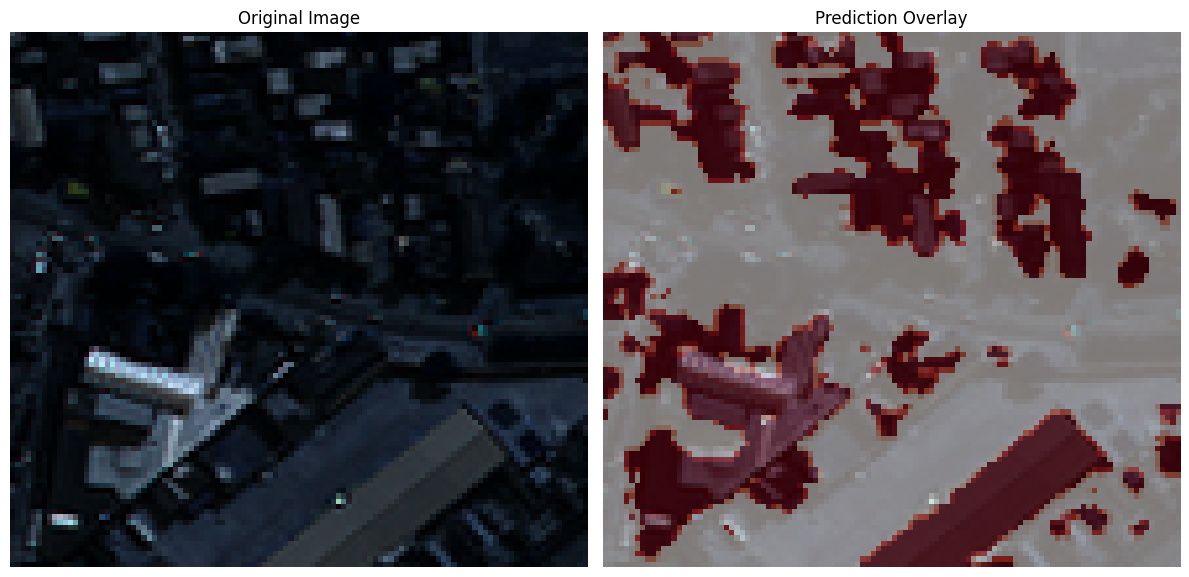

In [ ]:
from utils.Utilities import predict
import utils.Visualize as vs

image_path = "/content/datasets/test/8band/8band_AOI_2_RIO_img1210.tif"
prediction = predict(model, image_path, 128, 128)

vs.visualizeOriginalWithMask(image_path, prediction)

**Ensemble with SAM**

In [10]:
image_dir = "/content/datasets/test/3band"
unet_mask_dir = "/content/datasets/unet-masks/"
sam_mask_dir = "/content/datasets/sam-masks/"
os.makedirs(sam_mask_dir, exist_ok=True)

In [ ]:
from utils.Utilities import batch_predict_and_save
batch_predict_and_save(model, image_dir, unet_mask_dir, 128, 128)

**Installing SAM and download checkpoint**

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [15]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

DEVICE: cuda:0


In [16]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

In [17]:
import os
import cv2
import torch
import numpy as np
import rasterio
from PIL import Image
from tqdm import tqdm

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])

for fname in tqdm(image_files, desc="SAM Ensemble"):
    image_path = os.path.join(image_dir, fname)
    base_name = os.path.splitext(fname)[0]
    unet_mask_path = os.path.join(unet_mask_dir, f"{base_name}.png")
    sam_mask_path = os.path.join(sam_mask_dir, f"{base_name}_sam_mask.png")

    # Skip if missing
    if not os.path.exists(unet_mask_path):
        print(f"[Skip] Missing U-Net mask: {unet_mask_path}")
        continue

    # Load image (for SAM input)
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3]).transpose(1, 2, 0)
    predictor.set_image(image)

    # Load and binarize U-Net mask
    mask = cv2.imread(unet_mask_path, cv2.IMREAD_GRAYSCALE)
    binary_mask = (mask > 0.5).astype(np.uint8) * 255

    # Find contours -> bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print(f"[Note] No buildings found in {base_name}")
        continue

    boxes = [cv2.boundingRect(cnt) for cnt in contours]
    input_boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

    # SAM prediction
    all_sam_masks = []
    for box in input_boxes:
        masks, _, _ = predictor.predict(box=box, multimask_output=False)
        all_sam_masks.append(masks[0])

    # Combine all SAM masks
    final_mask = np.any(all_sam_masks, axis=0).astype(np.uint8) * 255

    # Save as PNG
    cv2.imwrite(sam_mask_path, final_mask)

print("\n✅ All SAM masks saved to:", sam_mask_dir)

SAM Ensemble:   0%|          | 10/2795 [00:05<22:43,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1006


SAM Ensemble:   0%|          | 11/2795 [00:05<21:41,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1007


SAM Ensemble:   0%|          | 12/2795 [00:06<20:57,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1008


SAM Ensemble:   1%|          | 31/2795 [00:15<21:40,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1025


SAM Ensemble:   1%|▏         | 36/2795 [00:18<22:44,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img103


SAM Ensemble:   1%|▏         | 41/2795 [00:20<23:35,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1034


SAM Ensemble:   2%|▏         | 44/2795 [00:22<22:58,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1037


SAM Ensemble:   2%|▏         | 60/2795 [00:30<21:27,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1051


SAM Ensemble:   2%|▏         | 66/2795 [00:33<21:10,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1057


SAM Ensemble:   3%|▎         | 70/2795 [00:35<21:41,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1060


SAM Ensemble:   3%|▎         | 73/2795 [00:36<22:09,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1063


SAM Ensemble:   3%|▎         | 85/2795 [00:43<22:37,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1074


SAM Ensemble:   3%|▎         | 86/2795 [00:43<21:29,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1075


SAM Ensemble:   3%|▎         | 90/2795 [00:45<22:18,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1079


SAM Ensemble:   3%|▎         | 94/2795 [00:47<22:07,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1082


SAM Ensemble:   4%|▍         | 119/2795 [01:00<21:11,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1104


SAM Ensemble:   4%|▍         | 125/2795 [01:03<22:05,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img111


SAM Ensemble:   5%|▍         | 138/2795 [01:10<22:52,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1121


SAM Ensemble:   5%|▌         | 145/2795 [01:13<21:45,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1128


SAM Ensemble:   5%|▌         | 148/2795 [01:15<21:31,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1130


SAM Ensemble:   5%|▌         | 150/2795 [01:16<21:18,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1132


SAM Ensemble:   5%|▌         | 151/2795 [01:16<20:26,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1133


SAM Ensemble:   6%|▌         | 156/2795 [01:19<20:48,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1138


SAM Ensemble:   6%|▌         | 160/2795 [01:21<20:03,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1141


SAM Ensemble:   6%|▌         | 168/2795 [01:25<21:18,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1149


SAM Ensemble:   7%|▋         | 190/2795 [01:36<20:41,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1169


SAM Ensemble:   7%|▋         | 191/2795 [01:37<19:56,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img117


SAM Ensemble:   7%|▋         | 193/2795 [01:38<19:12,  2.26it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1171


SAM Ensemble:   7%|▋         | 207/2795 [01:45<21:22,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1184


SAM Ensemble:   7%|▋         | 209/2795 [01:46<21:00,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1186


SAM Ensemble:   8%|▊         | 213/2795 [01:48<20:49,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img119


SAM Ensemble:   8%|▊         | 223/2795 [01:53<20:45,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1199


SAM Ensemble:   8%|▊         | 231/2795 [01:57<22:43,  1.88it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1205


SAM Ensemble:   8%|▊         | 233/2795 [01:58<20:35,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1207


SAM Ensemble:   9%|▊         | 241/2795 [02:02<20:44,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1214


SAM Ensemble:   9%|▊         | 244/2795 [02:04<20:40,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1217


SAM Ensemble:   9%|▉         | 245/2795 [02:04<19:48,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1218


SAM Ensemble:   9%|▉         | 249/2795 [02:06<20:08,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1221


SAM Ensemble:   9%|▉         | 258/2795 [02:11<20:38,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img123


SAM Ensemble:   9%|▉         | 259/2795 [02:11<19:45,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1230


SAM Ensemble:   9%|▉         | 265/2795 [02:14<19:37,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1236


SAM Ensemble:  10%|▉         | 270/2795 [02:16<19:58,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1240


SAM Ensemble:  10%|▉         | 279/2795 [02:21<19:57,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1249


SAM Ensemble:  10%|█         | 281/2795 [02:22<19:47,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1250


SAM Ensemble:  10%|█         | 292/2795 [02:28<21:45,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1260


SAM Ensemble:  11%|█         | 296/2795 [02:30<20:37,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1264


SAM Ensemble:  11%|█         | 302/2795 [02:33<20:21,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img127


SAM Ensemble:  11%|█         | 307/2795 [02:36<20:44,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1274


SAM Ensemble:  11%|█         | 310/2795 [02:37<20:32,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1277


SAM Ensemble:  11%|█         | 312/2795 [02:38<20:45,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1279


SAM Ensemble:  11%|█▏        | 315/2795 [02:40<20:45,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1281


SAM Ensemble:  11%|█▏        | 316/2795 [02:40<19:42,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1282


SAM Ensemble:  11%|█▏        | 320/2795 [02:42<19:46,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1286


SAM Ensemble:  12%|█▏        | 324/2795 [02:44<19:32,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img129


SAM Ensemble:  12%|█▏        | 334/2795 [02:49<20:20,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1299


SAM Ensemble:  12%|█▏        | 335/2795 [02:50<19:22,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img13


SAM Ensemble:  12%|█▏        | 343/2795 [02:54<21:34,  1.89it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1306


SAM Ensemble:  12%|█▏        | 344/2795 [02:54<20:13,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1307


SAM Ensemble:  13%|█▎        | 364/2795 [03:05<19:37,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1325


SAM Ensemble:  13%|█▎        | 371/2795 [03:08<19:32,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1331


SAM Ensemble:  14%|█▍        | 402/2795 [03:24<19:07,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img136


SAM Ensemble:  14%|█▍        | 403/2795 [03:24<18:23,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1360


SAM Ensemble:  15%|█▍        | 408/2795 [03:27<19:38,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1365


SAM Ensemble:  15%|█▍        | 409/2795 [03:27<18:43,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1366


SAM Ensemble:  15%|█▍        | 411/2795 [03:28<18:00,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1368


SAM Ensemble:  15%|█▍        | 417/2795 [03:31<18:48,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1373


SAM Ensemble:  15%|█▍        | 418/2795 [03:31<18:07,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1374


SAM Ensemble:  15%|█▌        | 432/2795 [03:38<19:18,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1387


SAM Ensemble:  16%|█▌        | 436/2795 [03:40<18:53,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1390


SAM Ensemble:  16%|█▌        | 443/2795 [03:44<18:33,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1397


SAM Ensemble:  16%|█▌        | 444/2795 [03:44<17:54,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1398


SAM Ensemble:  16%|█▌        | 450/2795 [03:48<20:42,  1.89it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1402


SAM Ensemble:  16%|█▌        | 452/2795 [03:49<20:05,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1404


SAM Ensemble:  16%|█▋        | 459/2795 [03:52<18:37,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1410


SAM Ensemble:  16%|█▋        | 460/2795 [03:53<17:55,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1411


SAM Ensemble:  17%|█▋        | 464/2795 [03:54<17:51,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1415


SAM Ensemble:  17%|█▋        | 475/2795 [04:00<19:48,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1425


SAM Ensemble:  17%|█▋        | 479/2795 [04:02<19:25,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1429


SAM Ensemble:  17%|█▋        | 486/2795 [04:06<18:30,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1435


SAM Ensemble:  18%|█▊        | 491/2795 [04:08<18:40,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img144


SAM Ensemble:  18%|█▊        | 500/2795 [04:13<19:15,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1448


SAM Ensemble:  18%|█▊        | 507/2795 [04:16<19:10,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1454


SAM Ensemble:  19%|█▊        | 520/2795 [04:23<19:29,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1466


SAM Ensemble:  19%|█▊        | 524/2795 [04:25<18:59,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img147


SAM Ensemble:  19%|█▉        | 539/2795 [04:33<18:27,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1483


SAM Ensemble:  19%|█▉        | 544/2795 [04:36<18:26,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1488


SAM Ensemble:  20%|█▉        | 547/2795 [04:37<18:46,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1490


SAM Ensemble:  20%|█▉        | 555/2795 [04:41<16:59,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1498


SAM Ensemble:  20%|██        | 566/2795 [04:46<17:11,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1507


SAM Ensemble:  21%|██        | 574/2795 [04:51<18:30,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1514


SAM Ensemble:  21%|██        | 578/2795 [04:53<19:12,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1518


SAM Ensemble:  21%|██        | 589/2795 [04:58<17:49,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1528


SAM Ensemble:  21%|██▏       | 594/2795 [05:01<18:17,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1532


SAM Ensemble:  21%|██▏       | 597/2795 [05:02<18:32,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1535


SAM Ensemble:  21%|██▏       | 600/2795 [05:04<18:26,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1538


SAM Ensemble:  22%|██▏       | 601/2795 [05:04<17:29,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1539


SAM Ensemble:  22%|██▏       | 608/2795 [05:08<18:31,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1545


SAM Ensemble:  22%|██▏       | 609/2795 [05:09<17:33,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1546


SAM Ensemble:  22%|██▏       | 617/2795 [05:13<19:38,  1.85it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1553


SAM Ensemble:  22%|██▏       | 620/2795 [05:14<18:03,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1556


SAM Ensemble:  23%|██▎       | 649/2795 [05:30<18:05,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1582


SAM Ensemble:  23%|██▎       | 651/2795 [05:31<17:55,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1584


SAM Ensemble:  23%|██▎       | 653/2795 [05:32<17:43,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1586


SAM Ensemble:  24%|██▎       | 660/2795 [05:36<17:32,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1592


SAM Ensemble:  24%|██▍       | 681/2795 [05:47<17:09,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1610


SAM Ensemble:  25%|██▍       | 691/2795 [05:52<17:21,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img162


SAM Ensemble:  25%|██▌       | 699/2795 [05:56<18:08,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1627


SAM Ensemble:  25%|██▌       | 706/2795 [05:59<16:37,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1633


SAM Ensemble:  25%|██▌       | 710/2795 [06:01<16:40,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1637


SAM Ensemble:  26%|██▌       | 716/2795 [06:05<17:26,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1642


SAM Ensemble:  26%|██▌       | 718/2795 [06:05<16:44,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1644


SAM Ensemble:  26%|██▋       | 736/2795 [06:15<17:30,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1660


SAM Ensemble:  26%|██▋       | 737/2795 [06:16<16:33,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1661


SAM Ensemble:  26%|██▋       | 739/2795 [06:17<16:23,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1663


SAM Ensemble:  26%|██▋       | 740/2795 [06:17<15:45,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1664


SAM Ensemble:  27%|██▋       | 741/2795 [06:17<15:19,  2.23it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1665


SAM Ensemble:  27%|██▋       | 746/2795 [06:20<16:40,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img167


SAM Ensemble:  27%|██▋       | 747/2795 [06:20<15:57,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1670


SAM Ensemble:  27%|██▋       | 763/2795 [06:28<16:28,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1685


SAM Ensemble:  27%|██▋       | 765/2795 [06:29<16:02,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1687


SAM Ensemble:  28%|██▊       | 771/2795 [06:33<17:33,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1692


SAM Ensemble:  28%|██▊       | 774/2795 [06:34<16:18,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1695


SAM Ensemble:  28%|██▊       | 777/2795 [06:35<15:25,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1698


SAM Ensemble:  28%|██▊       | 780/2795 [06:37<15:21,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img170


SAM Ensemble:  28%|██▊       | 786/2795 [06:40<15:33,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1705


SAM Ensemble:  28%|██▊       | 789/2795 [06:41<15:09,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1708


SAM Ensemble:  29%|██▊       | 801/2795 [06:47<16:16,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1719


SAM Ensemble:  29%|██▉       | 808/2795 [06:51<16:22,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1725


SAM Ensemble:  29%|██▉       | 813/2795 [06:53<16:23,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img173


SAM Ensemble:  29%|██▉       | 814/2795 [06:54<15:37,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1730


SAM Ensemble:  29%|██▉       | 817/2795 [06:55<15:54,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1733


SAM Ensemble:  29%|██▉       | 819/2795 [06:56<15:24,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1735


SAM Ensemble:  29%|██▉       | 820/2795 [06:57<14:54,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1736


SAM Ensemble:  29%|██▉       | 823/2795 [06:58<14:53,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1739


SAM Ensemble:  30%|██▉       | 827/2795 [07:00<15:32,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1742


SAM Ensemble:  30%|██▉       | 830/2795 [07:01<15:43,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1745


SAM Ensemble:  30%|██▉       | 834/2795 [07:04<17:19,  1.89it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1749


SAM Ensemble:  31%|███       | 856/2795 [07:16<16:55,  1.91it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1769


SAM Ensemble:  31%|███       | 857/2795 [07:16<15:55,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img177


SAM Ensemble:  31%|███       | 858/2795 [07:16<15:11,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1770


SAM Ensemble:  31%|███       | 860/2795 [07:17<14:59,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1772


SAM Ensemble:  31%|███       | 866/2795 [07:20<15:38,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1778


SAM Ensemble:  31%|███       | 869/2795 [07:22<16:06,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1780


SAM Ensemble:  31%|███▏      | 877/2795 [07:26<16:09,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1788


SAM Ensemble:  31%|███▏      | 879/2795 [07:27<15:40,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img179


SAM Ensemble:  32%|███▏      | 882/2795 [07:29<15:05,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1792


SAM Ensemble:  32%|███▏      | 883/2795 [07:29<14:33,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1793


SAM Ensemble:  32%|███▏      | 888/2795 [07:31<15:09,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1798


SAM Ensemble:  32%|███▏      | 899/2795 [07:37<15:16,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1807


SAM Ensemble:  33%|███▎      | 914/2795 [07:45<15:36,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1820


SAM Ensemble:  33%|███▎      | 918/2795 [07:47<15:21,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1824


SAM Ensemble:  33%|███▎      | 921/2795 [07:48<14:58,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1827


SAM Ensemble:  34%|███▎      | 938/2795 [07:58<16:11,  1.91it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1842


SAM Ensemble:  34%|███▎      | 942/2795 [08:00<15:26,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1846


SAM Ensemble:  34%|███▍      | 944/2795 [08:01<14:55,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1848


SAM Ensemble:  34%|███▍      | 945/2795 [08:01<14:19,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1849


SAM Ensemble:  34%|███▍      | 946/2795 [08:01<13:54,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img185


SAM Ensemble:  34%|███▍      | 957/2795 [08:07<15:08,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img186


SAM Ensemble:  34%|███▍      | 960/2795 [08:09<14:59,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1862


SAM Ensemble:  34%|███▍      | 963/2795 [08:10<14:19,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1865


SAM Ensemble:  34%|███▍      | 964/2795 [08:10<13:51,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1866


SAM Ensemble:  35%|███▍      | 965/2795 [08:11<13:33,  2.25it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1867


SAM Ensemble:  35%|███▍      | 967/2795 [08:12<14:05,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1869


SAM Ensemble:  35%|███▌      | 981/2795 [08:20<15:43,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1881


SAM Ensemble:  35%|███▌      | 984/2795 [08:21<14:51,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1884


SAM Ensemble:  35%|███▌      | 987/2795 [08:23<14:49,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1887


SAM Ensemble:  35%|███▌      | 991/2795 [08:24<14:36,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1890


SAM Ensemble:  36%|███▌      | 995/2795 [08:27<14:36,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1894


SAM Ensemble:  36%|███▌      | 996/2795 [08:27<13:59,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1895


SAM Ensemble:  36%|███▌      | 1005/2795 [08:31<14:23,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1902


SAM Ensemble:  36%|███▋      | 1016/2795 [08:37<14:20,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1912


SAM Ensemble:  37%|███▋      | 1023/2795 [08:41<14:29,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1919


SAM Ensemble:  37%|███▋      | 1025/2795 [08:42<14:14,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1920


SAM Ensemble:  37%|███▋      | 1031/2795 [08:45<14:29,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1926


SAM Ensemble:  37%|███▋      | 1033/2795 [08:46<14:05,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1928


SAM Ensemble:  37%|███▋      | 1035/2795 [08:47<13:41,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img193


SAM Ensemble:  37%|███▋      | 1040/2795 [08:49<14:10,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1934


SAM Ensemble:  37%|███▋      | 1043/2795 [08:51<14:16,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1937


SAM Ensemble:  38%|███▊      | 1050/2795 [08:54<14:22,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1943


SAM Ensemble:  38%|███▊      | 1055/2795 [08:57<14:00,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1948


SAM Ensemble:  38%|███▊      | 1058/2795 [08:58<13:36,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1950


SAM Ensemble:  38%|███▊      | 1060/2795 [08:59<13:36,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1952


SAM Ensemble:  38%|███▊      | 1063/2795 [09:01<13:42,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1955


SAM Ensemble:  38%|███▊      | 1071/2795 [09:05<13:49,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1962


SAM Ensemble:  39%|███▊      | 1081/2795 [09:10<13:48,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1971


SAM Ensemble:  39%|███▉      | 1085/2795 [09:12<13:46,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1975


SAM Ensemble:  39%|███▉      | 1088/2795 [09:13<14:00,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1978


SAM Ensemble:  39%|███▉      | 1092/2795 [09:15<13:33,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1981


SAM Ensemble:  39%|███▉      | 1104/2795 [09:21<13:59,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1992


SAM Ensemble:  40%|███▉      | 1108/2795 [09:23<13:43,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1996


SAM Ensemble:  40%|███▉      | 1109/2795 [09:24<13:07,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1997


SAM Ensemble:  40%|███▉      | 1111/2795 [09:25<12:47,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img1999


SAM Ensemble:  40%|███▉      | 1116/2795 [09:27<13:22,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2001


SAM Ensemble:  40%|████      | 1119/2795 [09:28<12:41,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2004


SAM Ensemble:  40%|████      | 1121/2795 [09:29<12:39,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2006


SAM Ensemble:  40%|████      | 1129/2795 [09:33<13:06,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2013


SAM Ensemble:  41%|████      | 1141/2795 [09:39<13:09,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2024


SAM Ensemble:  41%|████      | 1145/2795 [09:41<13:34,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2028


SAM Ensemble:  41%|████      | 1152/2795 [09:45<13:51,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2034


SAM Ensemble:  41%|████▏     | 1158/2795 [09:48<13:12,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img204


SAM Ensemble:  42%|████▏     | 1168/2795 [09:53<13:17,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2049


SAM Ensemble:  42%|████▏     | 1175/2795 [09:57<13:36,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2055


SAM Ensemble:  42%|████▏     | 1181/2795 [10:00<13:35,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2060


SAM Ensemble:  42%|████▏     | 1184/2795 [10:01<13:33,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2063


SAM Ensemble:  43%|████▎     | 1206/2795 [10:13<13:36,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2083


SAM Ensemble:  43%|████▎     | 1215/2795 [10:18<13:10,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2091


SAM Ensemble:  44%|████▎     | 1216/2795 [10:18<12:30,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2092


SAM Ensemble:  44%|████▎     | 1217/2795 [10:18<12:03,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2093


SAM Ensemble:  44%|████▎     | 1218/2795 [10:19<11:44,  2.24it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2094


SAM Ensemble:  44%|████▎     | 1219/2795 [10:19<11:30,  2.28it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2095


SAM Ensemble:  44%|████▍     | 1228/2795 [10:24<13:14,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2102


SAM Ensemble:  44%|████▍     | 1231/2795 [10:26<13:12,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2105


SAM Ensemble:  44%|████▍     | 1240/2795 [10:30<13:19,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2113


SAM Ensemble:  45%|████▍     | 1245/2795 [10:33<12:43,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2118


SAM Ensemble:  45%|████▍     | 1246/2795 [10:33<12:08,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2119


SAM Ensemble:  45%|████▍     | 1254/2795 [10:37<12:44,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2126


SAM Ensemble:  45%|████▍     | 1256/2795 [10:38<12:21,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2128


SAM Ensemble:  45%|████▌     | 1259/2795 [10:40<12:33,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2130


SAM Ensemble:  45%|████▌     | 1260/2795 [10:40<12:00,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2131


SAM Ensemble:  45%|████▌     | 1264/2795 [10:42<12:04,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2135


SAM Ensemble:  45%|████▌     | 1267/2795 [10:44<12:15,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2138


SAM Ensemble:  46%|████▌     | 1274/2795 [10:47<11:52,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2144


SAM Ensemble:  46%|████▌     | 1276/2795 [10:48<11:52,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2146


SAM Ensemble:  46%|████▌     | 1282/2795 [10:51<12:27,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2151


SAM Ensemble:  46%|████▌     | 1285/2795 [10:53<11:41,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2154


SAM Ensemble:  46%|████▌     | 1287/2795 [10:54<11:59,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2156


SAM Ensemble:  47%|████▋     | 1308/2795 [11:05<12:12,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2175


SAM Ensemble:  47%|████▋     | 1309/2795 [11:05<11:38,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2176


SAM Ensemble:  47%|████▋     | 1315/2795 [11:08<12:18,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2181


SAM Ensemble:  47%|████▋     | 1317/2795 [11:09<11:43,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2183


SAM Ensemble:  47%|████▋     | 1319/2795 [11:10<11:23,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2185


SAM Ensemble:  48%|████▊     | 1329/2795 [11:15<11:56,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2194


SAM Ensemble:  48%|████▊     | 1333/2795 [11:17<11:40,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2198


SAM Ensemble:  48%|████▊     | 1336/2795 [11:19<11:36,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img220


SAM Ensemble:  48%|████▊     | 1339/2795 [11:20<11:45,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2202


SAM Ensemble:  48%|████▊     | 1345/2795 [11:23<11:22,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2208


SAM Ensemble:  48%|████▊     | 1346/2795 [11:23<10:59,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2209


SAM Ensemble:  48%|████▊     | 1348/2795 [11:24<10:45,  2.24it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2210


SAM Ensemble:  48%|████▊     | 1355/2795 [11:28<11:55,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2217


SAM Ensemble:  49%|████▊     | 1356/2795 [11:28<11:21,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2218


SAM Ensemble:  49%|████▊     | 1360/2795 [11:30<11:35,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2221


SAM Ensemble:  49%|████▉     | 1364/2795 [11:32<11:24,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2225


SAM Ensemble:  49%|████▉     | 1372/2795 [11:36<12:01,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2232


SAM Ensemble:  49%|████▉     | 1378/2795 [11:39<11:22,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2238


SAM Ensemble:  49%|████▉     | 1383/2795 [11:42<12:01,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2242


SAM Ensemble:  50%|████▉     | 1387/2795 [11:44<11:09,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2246


SAM Ensemble:  50%|████▉     | 1392/2795 [11:47<11:18,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2250


SAM Ensemble:  50%|█████     | 1408/2795 [11:55<11:06,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2265


SAM Ensemble:  50%|█████     | 1410/2795 [11:56<11:13,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2267


SAM Ensemble:  51%|█████     | 1430/2795 [12:06<11:14,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2285


SAM Ensemble:  51%|█████▏    | 1435/2795 [12:09<11:02,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img229


SAM Ensemble:  51%|█████▏    | 1439/2795 [12:11<10:43,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2293


SAM Ensemble:  52%|█████▏    | 1444/2795 [12:13<10:43,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2298


SAM Ensemble:  52%|█████▏    | 1446/2795 [12:14<10:13,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img23


SAM Ensemble:  52%|█████▏    | 1455/2795 [12:19<10:26,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2307


SAM Ensemble:  52%|█████▏    | 1463/2795 [12:23<10:11,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2314


SAM Ensemble:  53%|█████▎    | 1481/2795 [12:32<10:45,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2330


SAM Ensemble:  53%|█████▎    | 1482/2795 [12:32<10:17,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2331


SAM Ensemble:  53%|█████▎    | 1495/2795 [12:39<10:39,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2343


SAM Ensemble:  54%|█████▎    | 1501/2795 [12:42<11:04,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2349


SAM Ensemble:  54%|█████▍    | 1505/2795 [12:44<10:53,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2352


SAM Ensemble:  54%|█████▍    | 1507/2795 [12:45<10:41,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2354


SAM Ensemble:  54%|█████▍    | 1513/2795 [12:49<10:44,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img236


SAM Ensemble:  54%|█████▍    | 1516/2795 [12:50<10:22,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2362


SAM Ensemble:  55%|█████▍    | 1526/2795 [12:55<10:06,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2371


SAM Ensemble:  55%|█████▍    | 1531/2795 [12:57<09:49,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2376


SAM Ensemble:  55%|█████▍    | 1537/2795 [13:00<09:58,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2381


SAM Ensemble:  55%|█████▌    | 1539/2795 [13:01<09:41,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2383


SAM Ensemble:  55%|█████▌    | 1541/2795 [13:02<09:36,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2385


SAM Ensemble:  55%|█████▌    | 1545/2795 [13:04<09:57,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2389


SAM Ensemble:  55%|█████▌    | 1547/2795 [13:05<09:29,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2390


SAM Ensemble:  56%|█████▌    | 1567/2795 [13:16<10:33,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2408


SAM Ensemble:  56%|█████▋    | 1574/2795 [13:20<10:15,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2414


SAM Ensemble:  57%|█████▋    | 1590/2795 [13:28<09:35,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2429


SAM Ensemble:  57%|█████▋    | 1595/2795 [13:30<09:25,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2433


SAM Ensemble:  58%|█████▊    | 1608/2795 [13:37<10:14,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2445


SAM Ensemble:  58%|█████▊    | 1631/2795 [13:49<09:39,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2466


SAM Ensemble:  58%|█████▊    | 1634/2795 [13:51<09:26,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2469


SAM Ensemble:  59%|█████▊    | 1638/2795 [13:53<09:29,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2472


SAM Ensemble:  59%|█████▉    | 1652/2795 [14:00<09:27,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2485


SAM Ensemble:  59%|█████▉    | 1658/2795 [14:03<09:13,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2490


SAM Ensemble:  59%|█████▉    | 1661/2795 [14:05<09:08,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2493


SAM Ensemble:  59%|█████▉    | 1663/2795 [14:06<08:47,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2495


SAM Ensemble:  60%|██████    | 1688/2795 [14:19<09:35,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2517


SAM Ensemble:  61%|██████    | 1693/2795 [14:21<08:53,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2521


SAM Ensemble:  61%|██████    | 1697/2795 [14:23<08:47,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2525


SAM Ensemble:  61%|██████    | 1704/2795 [14:27<09:01,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2531


SAM Ensemble:  61%|██████▏   | 1716/2795 [14:33<08:34,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2542


SAM Ensemble:  61%|██████▏   | 1717/2795 [14:34<08:15,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2543


SAM Ensemble:  62%|██████▏   | 1720/2795 [14:35<08:23,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2546


SAM Ensemble:  62%|██████▏   | 1723/2795 [14:37<08:14,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2549


SAM Ensemble:  62%|██████▏   | 1725/2795 [14:38<08:12,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2550


SAM Ensemble:  62%|██████▏   | 1731/2795 [14:41<08:42,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2556


SAM Ensemble:  63%|██████▎   | 1747/2795 [14:48<08:03,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2570


SAM Ensemble:  63%|██████▎   | 1748/2795 [14:49<07:49,  2.23it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2571


SAM Ensemble:  63%|██████▎   | 1758/2795 [14:54<08:19,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2580


SAM Ensemble:  63%|██████▎   | 1770/2795 [15:00<08:21,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2591


SAM Ensemble:  63%|██████▎   | 1773/2795 [15:01<08:10,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2594


SAM Ensemble:  64%|██████▍   | 1789/2795 [15:09<08:03,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2608


SAM Ensemble:  64%|██████▍   | 1792/2795 [15:11<07:47,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2610


SAM Ensemble:  65%|██████▍   | 1803/2795 [15:17<08:21,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2620


SAM Ensemble:  65%|██████▍   | 1810/2795 [15:20<08:08,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2627


SAM Ensemble:  65%|██████▍   | 1811/2795 [15:21<07:45,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2628


SAM Ensemble:  65%|██████▌   | 1819/2795 [15:25<07:46,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2635


SAM Ensemble:  65%|██████▌   | 1822/2795 [15:26<07:39,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2638


SAM Ensemble:  65%|██████▌   | 1828/2795 [15:29<07:45,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2643


SAM Ensemble:  66%|██████▌   | 1833/2795 [15:32<08:10,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2648


SAM Ensemble:  66%|██████▌   | 1842/2795 [15:37<08:22,  1.90it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2656


SAM Ensemble:  66%|██████▌   | 1844/2795 [15:38<07:55,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2658


SAM Ensemble:  66%|██████▌   | 1847/2795 [15:39<07:34,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2660


SAM Ensemble:  66%|██████▌   | 1850/2795 [15:40<07:20,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2663


SAM Ensemble:  67%|██████▋   | 1866/2795 [15:49<07:40,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2678


SAM Ensemble:  67%|██████▋   | 1867/2795 [15:49<07:18,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2679


SAM Ensemble:  67%|██████▋   | 1882/2795 [15:57<07:53,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2692


SAM Ensemble:  68%|██████▊   | 1894/2795 [16:03<07:23,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2702


SAM Ensemble:  69%|██████▊   | 1916/2795 [16:14<07:17,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2722


SAM Ensemble:  69%|██████▉   | 1925/2795 [16:19<07:11,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2730


SAM Ensemble:  69%|██████▉   | 1933/2795 [16:23<07:08,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2738


SAM Ensemble:  69%|██████▉   | 1940/2795 [16:27<06:57,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2744


SAM Ensemble:  70%|██████▉   | 1951/2795 [16:32<07:13,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2754


SAM Ensemble:  70%|██████▉   | 1953/2795 [16:33<06:51,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2756


SAM Ensemble:  70%|██████▉   | 1954/2795 [16:34<06:33,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2757


SAM Ensemble:  70%|███████   | 1957/2795 [16:35<06:23,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img276


SAM Ensemble:  70%|███████   | 1961/2795 [16:37<06:55,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2763


SAM Ensemble:  70%|███████   | 1967/2795 [16:40<06:51,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2769


SAM Ensemble:  70%|███████   | 1969/2795 [16:41<06:43,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2770


SAM Ensemble:  71%|███████   | 1971/2795 [16:42<06:29,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2772


SAM Ensemble:  71%|███████   | 1972/2795 [16:43<06:15,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2773


SAM Ensemble:  71%|███████   | 1974/2795 [16:44<06:25,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2775


SAM Ensemble:  71%|███████▏  | 1996/2795 [16:55<06:07,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img2795


SAM Ensemble:  72%|███████▏  | 2003/2795 [16:58<06:44,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img285


SAM Ensemble:  72%|███████▏  | 2014/2795 [17:04<06:18,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img295


SAM Ensemble:  72%|███████▏  | 2024/2795 [17:09<06:32,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img303


SAM Ensemble:  73%|███████▎  | 2027/2795 [17:11<06:14,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img306


SAM Ensemble:  73%|███████▎  | 2028/2795 [17:11<05:58,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img307


SAM Ensemble:  73%|███████▎  | 2033/2795 [17:14<06:20,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img311


SAM Ensemble:  73%|███████▎  | 2046/2795 [17:21<06:18,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img323


SAM Ensemble:  73%|███████▎  | 2050/2795 [17:23<06:18,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img327


SAM Ensemble:  73%|███████▎  | 2054/2795 [17:25<05:55,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img330


SAM Ensemble:  74%|███████▎  | 2055/2795 [17:25<05:41,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img331


SAM Ensemble:  74%|███████▎  | 2057/2795 [17:26<05:49,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img333


SAM Ensemble:  74%|███████▍  | 2066/2795 [17:31<06:17,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img341


SAM Ensemble:  74%|███████▍  | 2070/2795 [17:33<05:48,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img345


SAM Ensemble:  74%|███████▍  | 2072/2795 [17:34<05:34,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img347


SAM Ensemble:  74%|███████▍  | 2077/2795 [17:36<05:37,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img351


SAM Ensemble:  74%|███████▍  | 2078/2795 [17:37<05:25,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img352


SAM Ensemble:  74%|███████▍  | 2082/2795 [17:39<05:56,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img356


SAM Ensemble:  75%|███████▍  | 2095/2795 [17:46<05:48,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img368


SAM Ensemble:  75%|███████▌  | 2103/2795 [17:50<05:21,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img375


SAM Ensemble:  75%|███████▌  | 2108/2795 [17:52<05:37,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img38


SAM Ensemble:  76%|███████▌  | 2115/2795 [17:56<05:44,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img386


SAM Ensemble:  76%|███████▌  | 2117/2795 [17:57<05:31,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img388


SAM Ensemble:  76%|███████▌  | 2121/2795 [17:59<05:27,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img391


SAM Ensemble:  76%|███████▌  | 2126/2795 [18:01<05:16,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img396


SAM Ensemble:  77%|███████▋  | 2143/2795 [18:10<05:31,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img410


SAM Ensemble:  77%|███████▋  | 2153/2795 [18:15<05:17,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img42


SAM Ensemble:  77%|███████▋  | 2156/2795 [18:17<05:21,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img422


SAM Ensemble:  77%|███████▋  | 2160/2795 [18:19<05:03,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img426


SAM Ensemble:  77%|███████▋  | 2166/2795 [18:22<05:20,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img431


SAM Ensemble:  78%|███████▊  | 2173/2795 [18:26<05:05,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img438


SAM Ensemble:  78%|███████▊  | 2177/2795 [18:28<05:16,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img441


SAM Ensemble:  78%|███████▊  | 2181/2795 [18:30<04:57,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img445


SAM Ensemble:  78%|███████▊  | 2183/2795 [18:31<04:41,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img447


SAM Ensemble:  78%|███████▊  | 2191/2795 [18:35<04:43,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img454


SAM Ensemble:  79%|███████▉  | 2211/2795 [18:45<04:37,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img472


SAM Ensemble:  80%|███████▉  | 2226/2795 [18:53<04:43,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img486


SAM Ensemble:  80%|███████▉  | 2231/2795 [18:56<04:37,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img490


SAM Ensemble:  80%|███████▉  | 2232/2795 [18:56<04:24,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img491


SAM Ensemble:  80%|████████  | 2238/2795 [19:00<04:48,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img497


SAM Ensemble:  80%|████████  | 2239/2795 [19:00<04:31,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img498


SAM Ensemble:  80%|████████  | 2248/2795 [19:05<04:27,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img505


SAM Ensemble:  81%|████████  | 2251/2795 [19:06<04:18,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img508


SAM Ensemble:  81%|████████  | 2266/2795 [19:14<04:30,  1.95it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img521


SAM Ensemble:  82%|████████▏ | 2278/2795 [19:20<04:24,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img532


SAM Ensemble:  82%|████████▏ | 2280/2795 [19:21<04:06,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img534


SAM Ensemble:  82%|████████▏ | 2285/2795 [19:24<04:10,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img539


SAM Ensemble:  82%|████████▏ | 2286/2795 [19:24<03:58,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img54


SAM Ensemble:  82%|████████▏ | 2293/2795 [19:28<04:05,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img546


SAM Ensemble:  82%|████████▏ | 2297/2795 [19:30<04:13,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img55


SAM Ensemble:  83%|████████▎ | 2312/2795 [19:38<03:53,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img563


SAM Ensemble:  83%|████████▎ | 2315/2795 [19:39<03:52,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img566


SAM Ensemble:  83%|████████▎ | 2321/2795 [19:42<03:59,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img571


SAM Ensemble:  83%|████████▎ | 2323/2795 [19:43<03:52,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img573


SAM Ensemble:  83%|████████▎ | 2328/2795 [19:46<03:55,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img578


SAM Ensemble:  83%|████████▎ | 2332/2795 [19:48<03:46,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img581


SAM Ensemble:  84%|████████▎ | 2335/2795 [19:50<03:57,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img584


SAM Ensemble:  84%|████████▎ | 2338/2795 [19:51<03:55,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img587


SAM Ensemble:  84%|████████▎ | 2339/2795 [19:52<03:41,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img588


SAM Ensemble:  84%|████████▍ | 2348/2795 [19:56<03:31,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img596


SAM Ensemble:  85%|████████▍ | 2366/2795 [20:05<03:29,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img611


SAM Ensemble:  85%|████████▍ | 2371/2795 [20:08<03:18,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img616


SAM Ensemble:  85%|████████▌ | 2386/2795 [20:16<03:33,  1.91it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img63


SAM Ensemble:  85%|████████▌ | 2389/2795 [20:17<03:24,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img632


SAM Ensemble:  86%|████████▌ | 2394/2795 [20:20<03:08,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img637


SAM Ensemble:  86%|████████▌ | 2395/2795 [20:20<03:01,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img638


SAM Ensemble:  86%|████████▌ | 2400/2795 [20:23<03:11,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img642


SAM Ensemble:  86%|████████▌ | 2401/2795 [20:23<03:03,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img643


SAM Ensemble:  86%|████████▋ | 2416/2795 [20:31<03:07,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img657


SAM Ensemble:  87%|████████▋ | 2418/2795 [20:32<02:56,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img659


SAM Ensemble:  87%|████████▋ | 2425/2795 [20:35<02:55,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img665


SAM Ensemble:  87%|████████▋ | 2431/2795 [20:38<03:01,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img670


SAM Ensemble:  87%|████████▋ | 2435/2795 [20:40<02:54,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img674


SAM Ensemble:  87%|████████▋ | 2438/2795 [20:42<02:44,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img677


SAM Ensemble:  87%|████████▋ | 2441/2795 [20:43<02:44,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img68


SAM Ensemble:  88%|████████▊ | 2446/2795 [20:46<02:49,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img684


SAM Ensemble:  88%|████████▊ | 2455/2795 [20:50<02:53,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img692


SAM Ensemble:  88%|████████▊ | 2461/2795 [20:53<02:45,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img698


SAM Ensemble:  88%|████████▊ | 2465/2795 [20:56<02:44,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img700


SAM Ensemble:  89%|████████▊ | 2477/2795 [21:02<02:45,  1.93it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img711


SAM Ensemble:  89%|████████▉ | 2500/2795 [21:14<02:22,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img732


SAM Ensemble:  90%|████████▉ | 2502/2795 [21:15<02:16,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img734


SAM Ensemble:  90%|████████▉ | 2507/2795 [21:17<02:16,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img739


SAM Ensemble:  90%|████████▉ | 2508/2795 [21:18<02:11,  2.19it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img74


SAM Ensemble:  90%|████████▉ | 2513/2795 [21:20<02:19,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img744


SAM Ensemble:  90%|█████████ | 2517/2795 [21:22<02:10,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img748


SAM Ensemble:  90%|█████████ | 2522/2795 [21:25<02:12,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img752


SAM Ensemble:  90%|█████████ | 2523/2795 [21:25<02:06,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img753


SAM Ensemble:  91%|█████████ | 2538/2795 [21:33<02:06,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img767


SAM Ensemble:  91%|█████████ | 2548/2795 [21:38<02:05,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img776


SAM Ensemble:  91%|█████████ | 2550/2795 [21:39<01:56,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img778


SAM Ensemble:  91%|█████████▏| 2555/2795 [21:41<01:51,  2.15it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img782


SAM Ensemble:  92%|█████████▏| 2566/2795 [21:47<01:52,  2.03it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img792


SAM Ensemble:  92%|█████████▏| 2567/2795 [21:47<01:47,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img793


SAM Ensemble:  92%|█████████▏| 2568/2795 [21:48<01:43,  2.20it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img794


SAM Ensemble:  92%|█████████▏| 2571/2795 [21:49<01:48,  2.06it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img797


SAM Ensemble:  92%|█████████▏| 2579/2795 [21:53<01:50,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img803


SAM Ensemble:  92%|█████████▏| 2580/2795 [21:54<01:43,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img804


SAM Ensemble:  92%|█████████▏| 2581/2795 [21:54<01:39,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img805


SAM Ensemble:  92%|█████████▏| 2582/2795 [21:55<01:35,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img806


SAM Ensemble:  93%|█████████▎| 2590/2795 [21:59<01:37,  2.11it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img813


SAM Ensemble:  93%|█████████▎| 2591/2795 [21:59<01:33,  2.18it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img814


SAM Ensemble:  93%|█████████▎| 2599/2795 [22:03<01:39,  1.97it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img821


SAM Ensemble:  93%|█████████▎| 2600/2795 [22:04<01:33,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img822


SAM Ensemble:  94%|█████████▎| 2618/2795 [22:13<01:28,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img839


SAM Ensemble:  94%|█████████▎| 2619/2795 [22:14<01:23,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img84


SAM Ensemble:  94%|█████████▍| 2622/2795 [22:15<01:21,  2.13it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img842


SAM Ensemble:  94%|█████████▍| 2634/2795 [22:21<01:17,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img853


SAM Ensemble:  94%|█████████▍| 2635/2795 [22:22<01:14,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img854


SAM Ensemble:  94%|█████████▍| 2636/2795 [22:22<01:11,  2.22it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img855


SAM Ensemble:  95%|█████████▍| 2642/2795 [22:25<01:15,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img860


SAM Ensemble:  95%|█████████▍| 2643/2795 [22:26<01:11,  2.12it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img861


SAM Ensemble:  95%|█████████▍| 2647/2795 [22:28<01:14,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img865


SAM Ensemble:  95%|█████████▌| 2656/2795 [22:32<01:06,  2.08it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img873


SAM Ensemble:  95%|█████████▌| 2660/2795 [22:34<01:06,  2.04it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img877


SAM Ensemble:  95%|█████████▌| 2665/2795 [22:37<01:05,  1.98it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img881


SAM Ensemble:  96%|█████████▌| 2671/2795 [22:40<01:03,  1.94it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img887


SAM Ensemble:  96%|█████████▌| 2676/2795 [22:43<00:58,  2.05it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img891


SAM Ensemble:  96%|█████████▌| 2677/2795 [22:43<00:55,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img892


SAM Ensemble:  96%|█████████▌| 2678/2795 [22:44<00:53,  2.21it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img893


SAM Ensemble:  96%|█████████▋| 2691/2795 [22:51<00:54,  1.92it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img904


SAM Ensemble:  96%|█████████▋| 2694/2795 [22:52<00:50,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img907


SAM Ensemble:  97%|█████████▋| 2705/2795 [22:58<00:45,  1.99it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img917


SAM Ensemble:  97%|█████████▋| 2707/2795 [22:59<00:42,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img919


SAM Ensemble:  97%|█████████▋| 2708/2795 [22:59<00:40,  2.16it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img92


SAM Ensemble:  97%|█████████▋| 2711/2795 [23:01<00:42,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img922


SAM Ensemble:  97%|█████████▋| 2714/2795 [23:02<00:38,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img925


SAM Ensemble:  97%|█████████▋| 2717/2795 [23:04<00:37,  2.09it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img928


SAM Ensemble:  97%|█████████▋| 2722/2795 [23:07<00:36,  2.02it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img932


SAM Ensemble:  98%|█████████▊| 2736/2795 [23:14<00:30,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img945


SAM Ensemble:  98%|█████████▊| 2738/2795 [23:15<00:26,  2.14it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img947


SAM Ensemble:  98%|█████████▊| 2745/2795 [23:18<00:23,  2.17it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img953


SAM Ensemble:  98%|█████████▊| 2746/2795 [23:19<00:21,  2.23it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img954


SAM Ensemble:  99%|█████████▊| 2758/2795 [23:25<00:18,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img965


SAM Ensemble:  99%|█████████▉| 2763/2795 [23:28<00:15,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img97


SAM Ensemble:  99%|█████████▉| 2766/2795 [23:29<00:14,  2.01it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img972


SAM Ensemble:  99%|█████████▉| 2775/2795 [23:34<00:09,  2.00it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img980


SAM Ensemble:  99%|█████████▉| 2776/2795 [23:34<00:09,  2.10it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img981


SAM Ensemble:  99%|█████████▉| 2779/2795 [23:36<00:07,  2.07it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img984


SAM Ensemble: 100%|██████████| 2795/2795 [23:44<00:00,  1.96it/s]

[Note] No buildings found in 3band_AOI_2_RIO_img999

✅ All SAM masks saved to: /content/datasets/sam-masks/


**Download SAM mask files**

In [19]:
import shutil
import zipfile

def zip_folder(folder_path, output_zip_path):
    """Zips the contents of a folder into a zip file.

    Args:
        folder_path: The path to the folder to be zipped.
        output_zip_path: The path to the output zip file.
    """

    with zipfile.ZipFile(output_zip_path, "w") as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path)

In [20]:
output_zip_path = "/content/datasets/unet-masks.zip"
zip_folder(sam_mask_dir, output_zip_path)

In [21]:
from google.colab import files
files.download(output_zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
!pip install pydensecrf

  Using cached pydensecrf-1.0rc3.tar.gz (1.0 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [26]:
fused_union_dir = "/content/datasets/fused-masks/union"
fused_weighted_dir = "/content/datasets/fused-masks/weighted"
fused_crf_dir = "/content/datasets/fused-masks/crf"

In [ ]:
def apply_crf(original_image, mask_probs):
    H, W = mask_probs.shape
    d = dcrf.DenseCRF2D(W, H, 2)

    probs = np.stack([1 - mask_probs, mask_probs], axis=0)
    unary = unary_from_softmax(probs)
    d.setUnaryEnergy(unary)

    feats = create_pairwise_bilateral(sdims=(10, 10), schan=(10, 10, 10),
                                      img=original_image, chdim=2)
    d.addPairwiseEnergy(feats, compat=10)

    Q = d.inference(5)
    refined = np.argmax(Q, axis=0).reshape((H, W))

    return refined.astype(np.uint8)

In [36]:
os.makedirs(fused_union_dir, exist_ok=True)
os.makedirs(fused_weighted_dir, exist_ok=True)
os.makedirs(fused_crf_dir, exist_ok=True)

In [47]:
for filename in tqdm(os.listdir(unet_mask_dir), desc="Fusion masks"):
    if not filename.endswith(".png"):
        continue

    base_name = os.path.splitext(filename)[0]
    unet_mask_path = os.path.join(unet_mask_dir, f"{base_name}.png")
    sam_mask_path = os.path.join(sam_mask_dir, f"{base_name}_sam_mask.png")

    # Skip if missing
    if not os.path.exists(sam_mask_path):
        print(f"[Skip] Missing SAM mask: {base_name}")
        continue

    unet_mask = np.array(Image.open(unet_mask_path)) / 255.0
    sam_mask = np.array(Image.open(sam_mask_path)) / 255.0

    # Union
    # union_mask = np.logical_or(unet_mask, sam_mask).astype(np.uint8) * 255
    # Image.fromarray(union_mask).save(os.path.join(fused_union_dir, filename))

    # Weighted Fusion
    alpha, beta = 0.6, 0.4
    weighted = alpha * unet_mask + beta * sam_mask
    weighted_mask = (weighted > 0.5).astype(np.uint8) * 255
    Image.fromarray(weighted_mask).save(os.path.join(fused_weighted_dir, filename))

    # CRF
    # original_image = dummy_rgb_image_from_mask(unet_path)  # Replace with true RGB image if available
    # crf_result = apply_crf(original_image, weighted)
    # Image.fromarray(crf_result * 255).save(os.path.join(fused_crf_dir, filename))


Fusion masks:   1%|▏         | 38/2795 [00:00<00:14, 186.79it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2756
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1739
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1249
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img587
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2627
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2376


Fusion masks:   3%|▎         | 84/2795 [00:00<00:12, 212.73it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2146
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2571
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img119
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1498
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img632
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2769
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1920


Fusion masks:   5%|▍         | 132/2795 [00:00<00:11, 224.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2414
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2383
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1221
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img356
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1415
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img431
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2658
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img822
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2060
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1281
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img739
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img74
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2225
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img945


Fusion masks:   6%|▋         | 177/2795 [00:00<00:12, 206.07it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2648
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1034
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img984
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2628


Fusion masks:   8%|▊         | 219/2795 [00:01<00:12, 198.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2610
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1792
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img236
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2531
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img782
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1934
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1627
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1325


Fusion masks:   9%|▉         | 265/2795 [00:01<00:12, 210.42it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1869
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1660
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2352
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img368
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1435
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2620
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img571
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img805
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img891


Fusion masks:  11%|█         | 309/2795 [00:01<00:11, 207.24it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img454
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img873
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2525
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1141
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2185
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img692
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img445
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1307
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img505


Fusion masks:  13%|█▎        | 373/2795 [00:01<00:11, 209.49it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2151
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2209
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1865
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1788
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1518
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2194
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img331
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1943
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img532
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1398


Fusion masks:  15%|█▍        | 415/2795 [00:02<00:11, 203.42it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img521
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2349
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img472
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2389
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img186
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1528


Fusion masks:  16%|█▋        | 458/2795 [00:02<00:11, 203.21it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img813
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2521
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2570
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img351
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1025
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2390


Fusion masks:  18%|█▊        | 504/2795 [00:02<00:10, 211.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img907
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2638
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img642
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1981
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1798
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img814
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2635
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1079
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1063
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1996
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img732


Fusion masks:  20%|█▉        | 547/2795 [00:02<00:10, 207.92it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img792
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1742
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img803
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2094
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img491
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img928
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2126


Fusion masks:  22%|██▏       | 616/2795 [00:02<00:10, 216.19it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2218
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img311
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img999
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img776
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2678
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1121
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1948
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1538
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1488


Fusion masks:  24%|██▍       | 665/2795 [00:03<00:09, 218.97it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1133
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img861
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img806
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2643
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img391
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img173
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2775
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1586
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1171


Fusion masks:  25%|██▌       | 709/2795 [00:03<00:09, 211.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1429
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2092
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2130
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1824
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1277
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img534
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1545


Fusion masks:  27%|██▋       | 752/2795 [00:03<00:10, 196.99it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1365


Fusion masks:  28%|██▊       | 792/2795 [00:03<00:10, 188.05it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1733
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1887
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1075
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1890


Fusion masks:  30%|██▉       | 838/2795 [00:04<00:09, 205.70it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1687
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2113
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2144
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1705
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1008
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1698
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img700
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img422
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1592
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1633


Fusion masks:  31%|███▏      | 880/2795 [00:04<00:09, 204.84it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img323
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1708
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2083
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1670
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2429


Fusion masks:  33%|███▎      | 923/2795 [00:04<00:09, 204.32it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1912
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img185
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img54
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2663
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img616
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1848
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1664


Fusion masks:  35%|███▌      | 986/2795 [00:04<00:08, 205.62it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1661
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2445
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1390
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2371
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1104
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img498
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img333


Fusion masks:  37%|███▋      | 1032/2795 [00:05<00:08, 212.07it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1051
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img111
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1006
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1556
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img447
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img63
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2738
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2293


Fusion masks:  38%|███▊      | 1076/2795 [00:05<00:08, 208.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img947
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img486
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2385
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img13
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1950
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img573
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img347
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img539
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img853


Fusion masks:  41%|████      | 1144/2795 [00:05<00:07, 217.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img97
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img84
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img767
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1780
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2433
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img388
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img177
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img804
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2183


Fusion masks:  43%|████▎     | 1188/2795 [00:05<00:07, 210.65it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2795
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img893
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1207
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1955
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img677
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1642
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img441
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1360
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2265
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1214
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1881


Fusion masks:  44%|████▍     | 1236/2795 [00:05<00:07, 220.62it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img123
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img698
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1584
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img860
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img23
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2128
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2594
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1719
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1230
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2095


Fusion masks:  46%|████▌     | 1282/2795 [00:06<00:06, 216.49it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2343
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1971
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2004
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1770
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img980
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2049
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2208
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img386


Fusion masks:  47%|████▋     | 1327/2795 [00:06<00:06, 220.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img752
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img566
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1778
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1306
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1962
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img965
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img972
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img778
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1374
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img734
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1387
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2135


Fusion masks:  49%|████▉     | 1372/2795 [00:06<00:06, 210.53it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2242
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2472
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1060
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1978
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2314
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1928
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img42
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1286


Fusion masks:  51%|█████▏    | 1438/2795 [00:06<00:06, 211.57it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2770
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2154
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1884
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img954
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img611
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2331
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img295
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2542
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img684
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img546


Fusion masks:  53%|█████▎    | 1483/2795 [00:07<00:06, 214.20it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img341
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1692
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img144
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1695
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2466
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2660
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2198
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2772
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img748


Fusion masks:  55%|█████▍    | 1529/2795 [00:07<00:05, 220.30it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1264
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1205
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1037
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img794
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2298
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img865
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img162
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img330


Fusion masks:  56%|█████▋    | 1578/2795 [00:07<00:05, 222.02it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1937
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img127
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1250
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1736
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1685
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1199
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1582
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img584
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1402
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1397
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1807


Fusion masks:  59%|█████▉    | 1646/2795 [00:07<00:05, 216.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1926
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1745
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img887
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img276
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1299
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1866


Fusion masks:  60%|██████    | 1690/2795 [00:08<00:05, 206.43it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2246
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1448
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img204
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1454
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2102
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1218
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img327
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1827
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2105


Fusion masks:  62%|██████▏   | 1735/2795 [00:08<00:05, 206.93it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2493
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img306
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img410
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img68
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2591


Fusion masks:  64%|██████▎   | 1777/2795 [00:08<00:04, 207.44it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2469
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img877
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1849
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img904
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2549
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img855
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2131
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img953
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2238


Fusion masks:  65%|██████▌   | 1819/2795 [00:08<00:04, 197.86it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img892
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2556
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2091
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1274
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2679


Fusion masks:  67%|██████▋   | 1862/2795 [00:08<00:04, 203.54it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1514
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1919
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2034
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img147
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1130
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img744
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1902


Fusion masks:  69%|██████▉   | 1926/2795 [00:09<00:04, 205.93it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1793
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1867
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2024
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2692
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1282
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1368
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img179
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1186
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1975


Fusion masks:  70%|███████   | 1968/2795 [00:09<00:04, 203.85it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1735
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1532
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2773
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2202
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2550
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img345
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1184


Fusion masks:  72%|███████▏  | 2011/2795 [00:09<00:03, 207.95it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img797
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1410
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2055
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img303
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1169
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2543
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1842
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img490


Fusion masks:  74%|███████▎  | 2057/2795 [00:09<00:03, 200.77it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2138
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1425
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img426
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2517
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1952
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img793
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1846


Fusion masks:  75%|███████▌  | 2104/2795 [00:10<00:03, 212.72it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1999
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2730
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img842
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2485
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img919


Fusion masks:  77%|███████▋  | 2150/2795 [00:10<00:02, 216.31it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img285
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img659
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2063
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1730
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img38
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img563
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1553
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1466
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1074


Fusion masks:  78%|███████▊  | 2194/2795 [00:10<00:02, 204.56it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2381
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img229
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1366
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1637
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img167
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img352
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2608
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2580
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img581


Fusion masks:  81%|████████  | 2257/2795 [00:10<00:02, 205.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1404
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2156
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img497
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2001
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2093
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1610
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2702
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1483


Fusion masks:  82%|████████▏ | 2303/2795 [00:11<00:02, 214.45it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img711
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2232
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2546
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1260
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img665
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1279
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img917
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1007
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img193


Fusion masks:  84%|████████▍ | 2351/2795 [00:11<00:01, 226.37it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1997
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2028
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1217
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img657
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img136
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2330
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2744
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1772
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2656
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img508
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img925
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img307
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2408
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1138
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img375
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img103
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img396


Fusion masks:  86%|████████▌ | 2404/2795 [00:11<00:01, 241.12it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2757
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1507
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img821
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img981
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1411
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img578
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1373
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2490
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1535
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2354
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1820


Fusion masks:  89%|████████▊ | 2475/2795 [00:11<00:01, 218.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1894
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img220
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img638
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2118
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1539
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2307
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2722
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1057
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img881


Fusion masks:  90%|█████████ | 2519/2795 [00:12<00:01, 208.82it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2763
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img129
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1663
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img674
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1644
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img170
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1862
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2754
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2210
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2495


Fusion masks:  92%|█████████▏| 2565/2795 [00:12<00:01, 213.60it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1992
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img117
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1149
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img753
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img438
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1331


Fusion masks:  94%|█████████▎| 2614/2795 [00:12<00:00, 223.95it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1132
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img922
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img670
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img637
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2119
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img839
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1128
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1082
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img588


Fusion masks:  95%|█████████▌| 2659/2795 [00:12<00:00, 207.15it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1240
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1546
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2285
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1725
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1236
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1490
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2175


Fusion masks:  97%|█████████▋| 2703/2795 [00:12<00:00, 213.16it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1895
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img643
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1665
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img55
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img854
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2217
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2006


Fusion masks:  99%|█████████▉| 2768/2795 [00:13<00:00, 199.55it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1769
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img932
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2181
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2250
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img92
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img596


Fusion masks: 100%|██████████| 2795/2795 [00:13<00:00, 209.52it/s]

[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2013
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2267
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2362
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2176
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img2221
[Skip] Missing SAM mask: 3band_AOI_2_RIO_img1749


In [38]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def visualize_with_multiple_masks(image_path, unet_mask=None, sam_mask=None, fusion_mask=None):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3]).transpose(1, 2, 0)
        image = image / image.max()

    plt.figure(figsize=(16, 8))

    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # U-Net mask
    if unet_mask is not None:
        plt.subplot(1, 4, 2)
        plt.imshow(image)
        plt.imshow(unet_mask, cmap="Reds", alpha=0.5)
        plt.title("U-Net Mask")
        plt.axis("off")

    # SAM mask
    if sam_mask is not None:
        plt.subplot(1, 4, 3)
        plt.imshow(image)
        plt.imshow(sam_mask, cmap="Greens", alpha=0.5)
        plt.title("SAM Mask")
        plt.axis("off")

    # Fused mask
    if fusion_mask is not None:
        plt.subplot(1, 4, 4)
        plt.imshow(image)
        plt.imshow(fusion_mask, cmap="Blues", alpha=0.5)
        plt.title("Fused Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

**Visualize all masks**

In [51]:
import cv2
import numpy as np

# Ensure image load as grayscale and numerical (0 or 1)
unet_mask = cv2.imread("/content/datasets/unet-masks/3band_AOI_2_RIO_img1067.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread("/content/datasets/sam-masks/3band_AOI_2_RIO_img1067_sam_mask.png", cv2.IMREAD_GRAYSCALE)

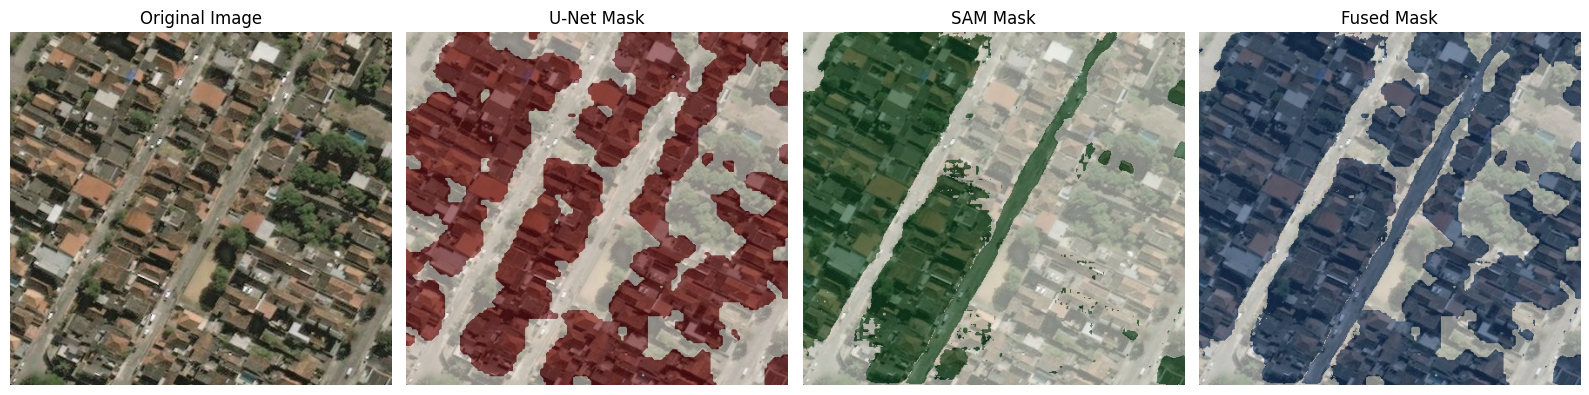

In [52]:
# Compare with union
fusion_mask = cv2.imread("/content/datasets/fused-masks/union/3band_AOI_2_RIO_img1067.png", cv2.IMREAD_GRAYSCALE)
visualize_with_multiple_masks(
    image_path="/content/datasets/test/3band/3band_AOI_2_RIO_img1067.tif",
    unet_mask=unet_mask,
    sam_mask=sam_mask,
    fusion_mask=fusion_mask
)

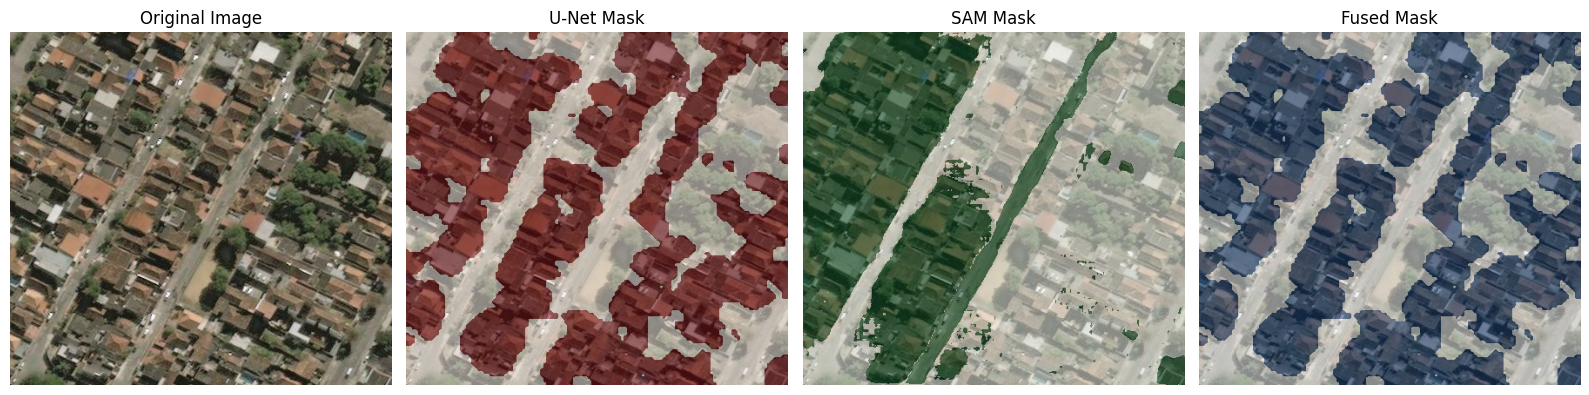

In [53]:
# Compare with weighted
fusion_mask = cv2.imread("/content/datasets/fused-masks/weighted/3band_AOI_2_RIO_img1067.png", cv2.IMREAD_GRAYSCALE)
visualize_with_multiple_masks(
    image_path="/content/datasets/test/3band/3band_AOI_2_RIO_img1067.tif",
    unet_mask=unet_mask,
    sam_mask=sam_mask,
    fusion_mask=fusion_mask
)